## Astro 330 "Computational Astrophysics"

### Homework 1 (60 points + 10 extra credit)

#### Distributed Wednesday, Oct 5; Due Wednesday, Oct 12 @ 5pm

<font color='blue' size=4> Total: 46 <br />
Problem 1: 8+2 </font>

<b>1. (10 points + 10 extra credit) <i>Finite differences.</i></b> Consider the 2nd order accurate finite difference scheme for the first derivative:
$$f^\prime(x)\approx \frac{f(x_{i+1})-f(x_{i-1})}{x_{i+1}-x_{i-1}}$$ 

a. (5 points + 10 points extra credit) We have used this scheme assuming constant spacing $x_{i+1}-x_i=h=\rm const$ to compute the logarithmic slope of the power spectrum, $P(k)$. However, it cannot be used for end points of the interval, $x_0$ and $x_{N-1}$ in this form. Use the method of undertermined coefficients described in S 1.1 in my <a href="http://astro.uchicago.edu/~andrey/classes/a330f16/notes.pdf">notes</a> to derive second order accurate difference scheme for $f^\prime$ for these end points. <font color='blue' size=4> **Comment on the difference from the above scheme.** (-2) </font> <b>Extra credit 10 points:</b> write a code that computes coefficients of difference schemes for derivative of any order to any specified order of accuracy using equations 1.8-1.9 in the notes. 





In [10]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.interpolate import UnivariateSpline
from codes.savitzky_golay_werrors import savgol_filter_werror
from codes.setup import data_home_dir
from codes.plot_utils import plot_pretty
from colossus.cosmology import cosmology

In [12]:
def der2_start(x,f):
    der2_start = (-1.5*f[0] + 2*f[1] -0.5*f[2])/(x[1] - x[0])
    return der2_start

def der2_end(x,f):
    der2_end = (1.5*f[len(f)-1] - 2*f[len(f)-2] +0.5*f[len(f)-3])/(x[len(x)-1] - x[len(x)-2])
    return der2_end

#
#Explain the above in Markdown format before submitting
#

def der2(x, f):
    """
    compute first derivative to 2nd order with corrections to end points
    """
    dummyx1 = np.roll(x,-1); dummyx2 = np.roll(x,1)
    dummyf1 = np.roll(f,-1); dummyf2 = np.roll(f,1)
    der2 = (dummyf1 - dummyf2)/(dummyx1 - dummyx2)
    
    der2[0] = der2_start(x,f)
    der2[len(der2)-1] = der2_end(x,f)
    
    return der2


def der2_old(x,f):
    dummyx1 = np.roll(x,-1); dummyx2 = np.roll(x,1)
    dummyf1 = np.roll(f,-1); dummyf2 = np.roll(f,1)
    der2_old = (dummyf1 - dummyf2)/(dummyx1 - dummyx2)
    der2_old[0]=(f[1] - f[0])/(x[1] - x[0])
    der2_old[len(der2_old)-1]=(f[len(f)-1] - f[len(f)-2])/(x[len(x)-1] - x[len(x)-2])
    return der2_old

  


In [11]:
# define a vector of cosmological parameters:    
my_cosmo = {'flat': True, 'H0': 70.0, 'Om0': 0.27, 'Ob0': 0.045714, 'sigma8': 0.82, 'ns': 0.96}
z = 0.0

# set my_cosmo to be the current cosmology	
cosmo = cosmology.setCosmology('my_cosmo', my_cosmo)
cosmo.interpolation = False

Rmin = 0.01; Rmax = 3000.0; 
lR = np.arange(np.log10(Rmin), np.log10(Rmax), 0.01); 
R = 10.**lR; M = cosmo.lagrangianM(R)

kmin = 1.e-5; kmax = 1.e2; dk = 1.e-2
lkmin = np.log10(kmin); lkmax = np.log10(kmax)

ka = np.arange(kmin, kmax, dk)
lka = np.arange(lkmin, lkmax, 0.01); #Evenly Spaced!
kalog = 10.0**lka

# input model spectrum for linearly spaced wavenumber values
Pka = cosmo.matterPowerSpectrum(ka, 'eh98')
# input model spectrum for comparison for logarithmically spaced wavenumber values
Pkalog = cosmo.matterPowerSpectrum(kalog, 'eh98')

funcint = np.zeros_like(R); funcintlog = np.zeros_like(R)

for i, Rd in enumerate(R):
    x = ka*Rd; xl = kalog*Rd
    # set up integrands for linear and log spacings of k
    funcd     = (3.*(np.sin(x)-x*np.cos(x))/(x**3))**2*ka**2*Pka
    funcdlog  = (3.*(np.sin(xl)-xl*np.cos(xl))/(xl**3))**2*kalog**3*Pkalog
    # approximate the functions with spline
    splint    = UnivariateSpline(ka, funcd, s=0.0)
    splintlog = UnivariateSpline(lka, funcdlog, s=0.0)
    # get integral from spline
    funcint[i] = splint.integral(kmin, kmax)
    funcintlog[i] = splintlog.integral(lkmin, lkmax)

# compute rms and normalize properly
funcint = np.sqrt(funcint/(2.*np.pi**2))
# ln(10) factor converts dlog10(k) to dln(k)
funcintlog = np.sqrt(funcintlog*np.log(10)/(2.*np.pi**2))


For end points using undetermined coefficients:

Start End Point:

$f'(x) = Af(x) + Bf(x+h) + Cf(x+2h)$ <br>
$f'(x) \approx Af(x) + B[f(x) + h f'(x) + \frac{h^2}{2} f''(x)] + C[f(x) + 2h f'(x) + \frac{4 h^2}{2} f''(x)]$ <br>
$f'(x) \approx (A + B + C) f(x) + (B + 2C)h f(x) + (B + 4C)\frac{h^2}{2} f''(x)$ <br>

Equations needed to be solved:
<br>
$A + B + C = 0$<br>
$B + 2C = \frac{1}{h}$<br>
$B + 4C = 0$
<br>

Solutions:
<br>
A = $\frac{-3}{2h}$<br>
B = $\frac{2}{h}$<br>
C = $\frac{-1}{2h}$<br>
<br>

$$f'(x) \approx \frac{-1.5f(x) + 2f(x+h) - 0.5f(x+2h)}{h}$$
2nd order approx. because of the (f'''(x)/h) term which is O($h^2$)


Similarly, for Final Point:

$f'(x) = Af(x) + Bf(x-h) + Cf(x-2h)$ <br>
<br>
with solutions as 

Solutions:
<br>
A = -$\frac{-3}{2h}$<br>
B = -$\frac{2}{h}$<br>
C = -$\frac{-1}{2h}$<br>
<br>

$$f'(x) \approx \frac{1.5f(x) - 2f(x-h) + 0.5f(x-2h)}{h}$$


First point derivative: Difference is 1.170e-07
Last point derivative: Difference is 1.697e-04


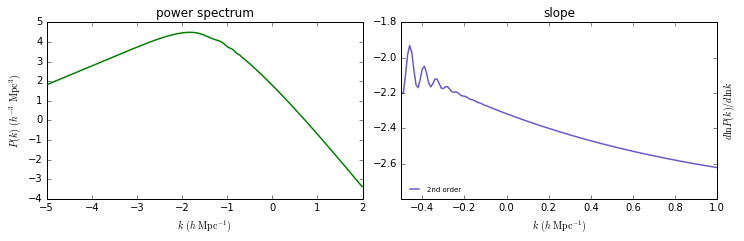

In [13]:
dlPdlk2 = der2(lka,np.log10(Pkalog))
dlPdlk2_old = der2_old(lka,np.log10(Pkalog))

#######################
fig, ax = plt.subplots(1,2,figsize=(10.,3.))
fig.tight_layout()

ax[0].plot(lka, np.log10(Pkalog), lw=1.5, c='g', label='$P(k)')
ax[0].set_xlabel('$k\ (h\ \mathrm{Mpc}^{-1})$'); ax[0].set_ylabel('$P(k)\ (h^{-3}\ \mathrm{Mpc}^3)$')
#ax[0].set_xlim(-5.,1.); ax[1].set_ylim(-3.,1.)
ax[0].set_title('power spectrum')
ax[1].grid()

ax[1].set_xlabel('$k\ (h\ \mathrm{Mpc}^{-1})$')
ax[1].set_ylabel(r'$d\ln P(k)/d\ln k$')
ax[1].yaxis.set_label_position('right')
ax[1].set_xlim(-0.5,1.); ax[1].set_ylim(-2.8,-1.8)
ax[1].set_title('slope')
ax[1].plot(lka,(dlPdlk2), lw=1.5, c='slateblue', label='2nd order')
ax[1].legend(loc='lower left', frameon=False, fontsize=7)
ax[1].grid()

#ax[2].plot(lka, abs(dlPdlk2 - dlPdlk2_old)/dlPdlk2_old, lw=1.5, c='slateblue', label='2nd order')

print 'First point derivative: Difference is %.3e' %abs((dlPdlk2[0] - dlPdlk2_old[0])/dlPdlk2_old[0])
print 'Last point derivative: Difference is %.3e' % abs((dlPdlk2[len(dlPdlk2)-1] - dlPdlk2_old[len(dlPdlk2)-1])/dlPdlk2_old[len(dlPdlk2)-1])
plt.show()

For a general order derivative and a general order accuracy
![title](data/screenshot.png)

In [35]:

M = np.array([ [1,-2,-1], [2,2,-1], [-1,-1,2] ])
c = np.array([6,1,1])
y = np.linalg.solve(M,c)
print y

[ 3. -2.  1.]


In [1]:
#Solving general order derivative and a general order accuracy (Eq. 1.8 and 1.9 in notes)

from numpy import linalg
import math
##########################################################
def c_j(k,N,p):
    A_ij = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            A_ij[i][j] = ((j-p)**i)/float(math.factorial(i))
            
    
    d_ik = np.zeros(N)
    d_ik[k] = 1
    
    c_ikj = np.linalg.solve(A_ij,d_ik)   #Equation 1.9 in notes
    return c_ikj
##########################################################
def deriv_general(f,x,k,N,p):
    
    Nmax = N+k
    
    h = x[1]-x[0]; hk = 1/h**k
    a = x[0]; b = x[-1]
    xx = np.arange(a+h, b-h, h)

    
    cj = c_j(k,Nmax,p)
    
    print cj
    
    sumj = 0
    for j in range(Nmax):    #Equation 1.8 in notes
        fj = f[j]
        sumj += cj[j]*fj  
    #Higher order derivative (N+1) term truncated: #R = j**i/math.factorial(N+1)*cj
    deriv = sumj*1/hk
    return deriv

f = np.array([2.,1.,2.])
x = np.array([0.,1.,2.])

print deriv_general(f,x,2,1,1)
    

[ 1. -2.  1.]
2.0


<font color='blue' size=4> The extra-credit problem did not work correctly (+2 for effort) </font>

b. (5 points) In class and in the notes I derived finite difference schemes for derivatives of different order using Taylor expansion and assuming constant spacing between points: $x_{i+1}-x_i=h=\rm const$. Examine the finite difference scheme for the first derivative 
in the case of non-constant spacing (i.e., $x_{i+1}-x_{i}\neq \rm const$). <font color='blue' size=4> **What is the order of the scheme in this case?** (-2) </font>
Derive the second order scheme for such case and comment is what is different compared to the scheme above for constant $h$.

In [ ]:
#Look at notebook - solved for first order and second order


def der2_unequal(x, f):
    """
    compute first derivative to 2nd order with corrections to end points
    """
    
    dummyx1 = np.roll(x,-1); dummyx2 = np.roll(x,1); dummyx = x
    dummyf1 = np.roll(f,-1); dummyf2 = np.roll(f,1); dummyf = f
    
    h1 = dummyx2 - dummyx
    h2 = dummyx - dummyx1
    
    der2 = (1/(h1+h2))*((h1/h2)*(dummyf-dummyf1) +(h2/h1)*(dummyf2-dummyf))
    
    #der2 = (dummyf1 - dummyf2)/(dummyx1 - dummyx2)
    der2[0]=(f[1] - f[0])/(x[1] - x[0])
    der2[len(der2)-1]=(f[len(f)-1] - f[len(f)-2])/(x[len(x)-1] - x[len(x)-2])

    
    return der2

#der = der2_unequal(k,Pk)


<font color='blue' size=4> In python you can use standard python list/arrays indexing, which is more convenient. For example, in `f[len(f)-2]` you can omit `len(f)` and just write `f[-2]`.</font> 

Changing Step Size : 

h1 --> forward step
h2 --> backward step; where h1 $!=$ h2

(Eq. 1) $f(x+h_1) \approx f(x) + h_1 f'(x) + \frac{h_1^2}{2} f''(x)$<br> 
(Eq. 2) $f(x-h_2) \approx f(x) - h_2 f'(x) + \frac{h_2^2}{2} f''(x)$<br>

Multiplying 1 by $h2^2$ and 2 by $h1^2$: <br>

$h_1^2 f(x-h_2) - h_2^2 f(x+h_1) =\ ...$

$$f'(x) \approx \frac{\frac{h_1(f(x) - f(x-h_2))}{h_2} + \frac{h_2(f(x +h_1) - f(x))}{h_1} }{(h_1 + h_2)}$$

Here we roughly multiply by O($h^2$) and divide by O($h^3$), while the truncating term is O($h^3$).
Hence, this is to second order accuracy, using evaluation of one extra function.

<font color='blue' size=4> Problem 2: 9 </font>

<b>2. (10 points) <i>Smoothing</i>.</b> A code snippet below reads in density profile of a dark matter halo from a $\Lambda$Cold Dark Matter simulation. We are interested in a smooth behavior of the profile, but existence of substructure (in the form of subhalos and density inhomogeneities) generates fluctuations in the overall profile. These fluctuations are estimated by splitting radial shells into equal volume sectors and estimating distribution of densities in these sectors. The code reads in profile of median density and its errors. The task here is to estimate the slope of the smooth profile. Do this with the second order accurate difference scheme with the scheme you devised in 1a for the end points. 

a. (5 points) Choose appropriate smoothing scale $s$ to be used with <a href="http://docs.scipy.org/doc/scipy-0.18.0/reference/generated/scipy.interpolate.UnivariateSpline.html">UnivariateSpline</a> routine and compute and plot the profile of logarithmic slope of the density profile, $d\log\rho/d\log r$, using the smoothed spline with smoothing appropriate for the profile uncertainties. Compare with the slope of unsmoothed profile and with spline with $s=0$. 



In [18]:
# profile reading code


fname = data_home_dir()+'halo_density_profile.dat'

# r in /h Mpc, densities are in units of the mean density of the universe at that epoch
r, d50, err = np.loadtxt(fname, usecols=(0,2,5), unpack=True)
ld50 = np.log10(d50); lr = np.log10(r)

dld50dlr=der2(lr,ld50) #Derivative with finite differences

###Fitting spline and taking slope###
spline_density_s0    = UnivariateSpline(lr, ld50, s=0)
slope_density_s0= spline_density_s0.derivative()

##################################################

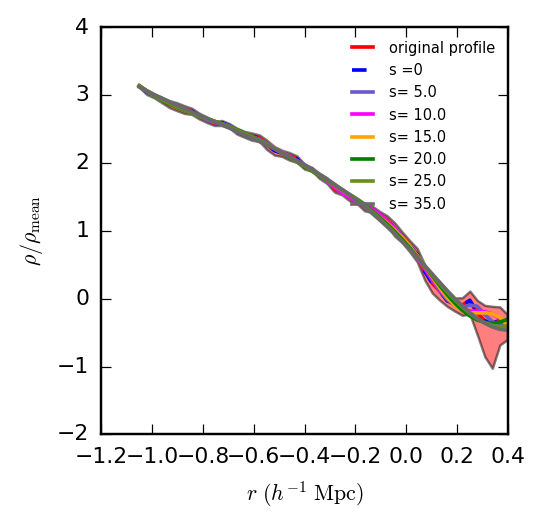

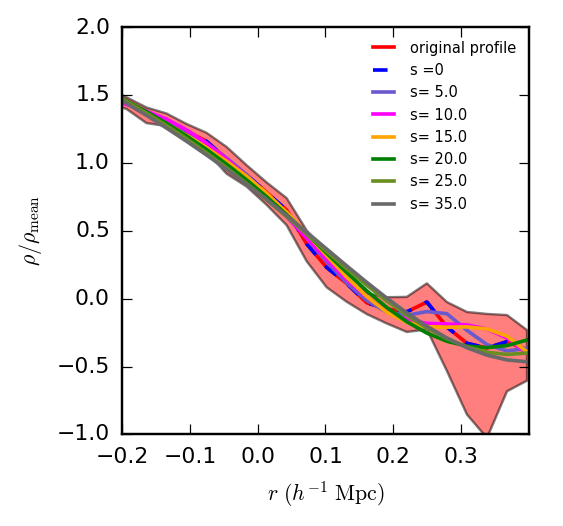

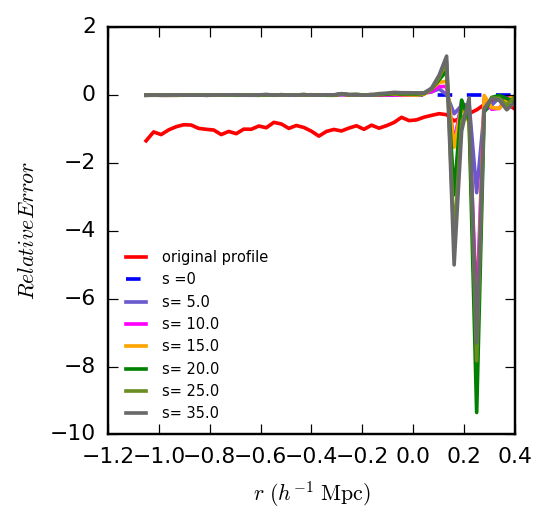

In [19]:
slist = [5,10,15,20,25,35]
c = ['slateblue', 'magenta', 'orange', 'green','olivedrab','dimgrey' ]
#smoothen = 15
weight = 1/np.log10((d50+err)/(d50))

##Plotting function and comparing with Spline interpolation

plot_pretty()
plt.figure(figsize=(3,3))
plt.xlabel(r'$r\ (h^{-1}\ \rm Mpc)$'); plt.ylabel(r'$\rho/\rho_{\rm mean}$')
#plt.xlim(0.05,3.); plt.ylim(0.1, 5.e3)
#plt.xscale('log'); plt.yscale('log')
plt.plot(lr, ld50, c='r', lw=1.5, label='original profile')
plt.plot(lr, spline_density_s0(lr),'--', c='b', lw=1.5, label='s =0')
    
for i,smoothen in enumerate(slist):
    spline_density = UnivariateSpline(lr, ld50, s=smoothen, w=weight)
    plt.plot(lr, spline_density(lr), c=c[i], lw=1.5, label='s= %.1f'%smoothen)
  
plt.fill_between(lr, np.log10(d50-err), np.log10(d50+err), facecolor='red', alpha=0.5)
plt.legend(frameon=False, fontsize=6)
plt.show()
    
#    
##Comparing with Splines in fixed regime of higher r
#

plot_pretty()
plt.figure(figsize=(3,3))
plt.xlabel(r'$r\ (h^{-1}\ \rm Mpc)$'); plt.ylabel(r'$\rho/\rho_{\rm mean}$')
plt.xlim(-0.2,0.4); 
plt.ylim(-1, 2)
#plt.xscale('log'); plt.yscale('log')
plt.plot(lr, ld50, c='r', lw=1.5, label='original profile')
plt.plot(lr, spline_density_s0(lr),'--', c='b', lw=1.5, label='s =0')
    
for i,smoothen in enumerate(slist):
    spline_density = UnivariateSpline(lr, ld50, s=smoothen, w=weight)
    plt.plot(lr, spline_density(lr), c=c[i], lw=1.5, label='s= %.1f'%smoothen)
#  
plt.fill_between(lr, np.log10(d50-err), np.log10(d50+err), facecolor='red', alpha=0.5)
plt.legend(frameon=False, fontsize=6)
plt.show()


#
##Relative errors compared
#

plot_pretty()
plt.figure(figsize=(3,3))
plt.xlabel(r'$r\ (h^{-1}\ \rm Mpc)$'); plt.ylabel(r'$Relative Error$')
#plt.xlim(-0.2,0.4); 
#plt.ylim(-1, 2)
#plt.xscale('log'); plt.yscale('log')
plt.plot(lr, np.log10(err/d50), c='r', lw=1.5, label='original profile')
plt.plot(lr, np.abs(spline_density_s0(lr) - ld50)/ld50,'--', c='b', lw=1.5, label='s =0')
    
for i,smoothen in enumerate(slist):
    spline_density = UnivariateSpline(lr, ld50, s=smoothen, w=weight)
    plt.plot(lr, np.abs(spline_density(lr) - ld50)/ld50, c=c[i], lw=1.5, label='s= %.1f'%smoothen)
  
    # plt.fill_between(lr, np.log10(d50-err), np.log10(d50+err), facecolor='red', alpha=0.5)

plt.legend(frameon=False, fontsize=6, loc = 'lower left')
plt.show()





<font color='blue' size=4> The last plot is confusing as it compares different. You compare log(relative err) to abs(deviation of spline). <br />
Shown comparison of results for different values of $s$, but otherwise no quantitative explanation for the chosen $s$. (-1)
</font>

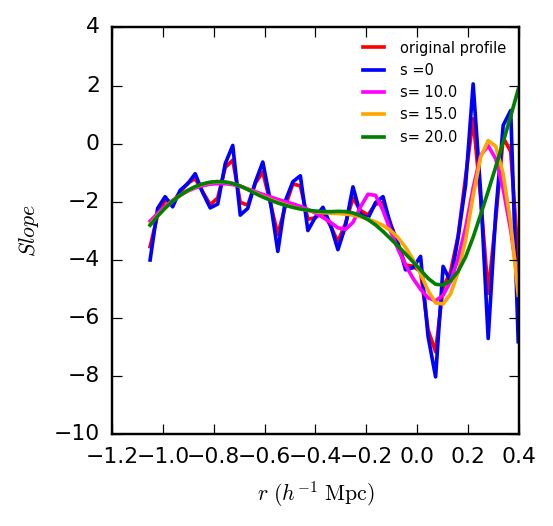

In [20]:
#Comparing Slopes from spline and finite differences

plot_pretty()
plt.figure(figsize=(3,3))
plt.xlabel(r'$r\ (h^{-1}\ \rm Mpc)$'); plt.ylabel(r'$Slope$')
#plt.xlim(-0.2,0.4); 
#plt.ylim(-1, 2)
#plt.xscale('log'); plt.yscale('log')
plt.plot(lr, dld50dlr, c='r', lw=1.5, label='original profile')
plt.plot(lr, slope_density_s0(lr),'-', c='b', lw=1.5, label='s =0')
    
    
for i,smoothen in enumerate(slist):
    spline_density = UnivariateSpline(lr, ld50, s=smoothen, w=weight)
    slope_density = spline_density.derivative()
    if smoothen ==10 or smoothen==15 or smoothen==20:
        plt.plot(lr, slope_density(lr), c=c[i], lw=1.5, label='s= %.1f'%smoothen)
  
plt.legend(frameon=False, fontsize=6)
plt.show()




 Best Case Spline : s = 15 or s =20. Recompute that and display below 
---> s = 15 preferred

b. (5 points) Use Surhud More's routine for Savitzky-Golay filter taking into account error bars (see <a href="http://ascl.net/1601.012">More, S. 2016</a>) in codes/savitzky_golay_werrors.py to compute the filtered profile and compute its logarithmic slope profile. Compare to the slope of unsmoothed profile and the best result from the spline above. 

Examples of how to use savitzky_golay_werrors.py are given in <a href="https://github.com/a-kravtsov/a330f16/blob/master/ex02.ipynb">ex02 notebook.</a> More examples, including example of how to treat correlated errors (not relevant for this problem, but may be relevant in your research in the future) can be found in tests.py in Surhud's original <a href="https://github.com/surhudm/savitzky_golay_with_errors">repository</a>. 

If you are curious, you can find examples of using Savitzky-Golay filter in this context in both theoretical and observational analysis in these recent papers: <a href="http://adsabs.harvard.edu/abs/2014ApJ...789....1D">Diemer & Kravtsov (2014)</a> <a href="http://adsabs.harvard.edu/abs/2016ApJ...825...39M">More et al. 2016</a>, <a href="http://adsabs.harvard.edu/abs/2016JCAP...07..022A">Adhikari et al. (2016)</a>. 

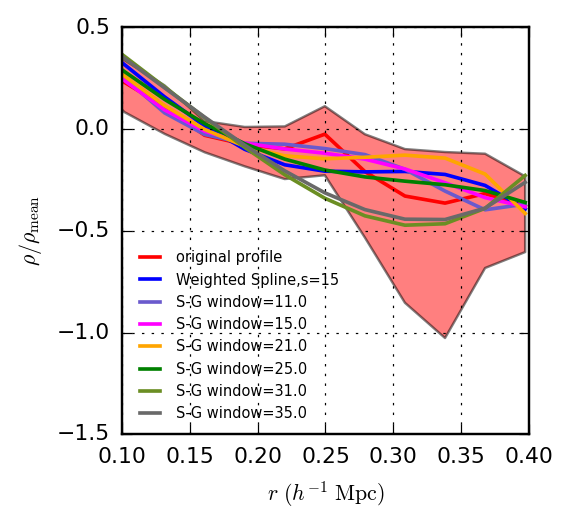

In [22]:
window_size = [11,15,21,25,31,35]
order = 5

spline_density = UnivariateSpline(lr, ld50, s=15, w=weight)
slope_density = spline_density.derivative()

c = ['slateblue', 'magenta', 'orange', 'green','olivedrab','dimgrey']


plot_pretty()
plt.figure(figsize=(3,3))
plt.xlabel(r'$r\ (h^{-1}\ \rm Mpc)$'); plt.ylabel(r'$\rho/\rho_{\rm mean}$')
plt.xlim(0.1,0.4); plt.ylim(-1.5, .5)
#plt.xscale('log'); plt.yscale('log')
plt.plot(lr, ld50, c='r', lw=1.5, label='original profile')
plt.plot(lr, spline_density(lr), c='b', lw=1.5, label='Weighted Spline,s=15')

for i,window in enumerate(window_size):
    sg = savgol_filter_werror(ld50, window, order, np.log((d50-err)/d50), deriv=None)
    plt.plot(lr, sg, c=c[i], lw=1.5, label='S-G window=%.1f'%window)
#plt.plot(lr, spline_density_s0(lr),'--', c='b', lw=1.5, label='Spline with s0')

plt.fill_between(lr, np.log10(d50-err), np.log10(d50+err), facecolor='red', alpha=0.5)

plt.legend(frameon=False, fontsize=6, loc = 'lower left')
plt.grid()
plt.show()


#Pick window_size = 25 and compare slope

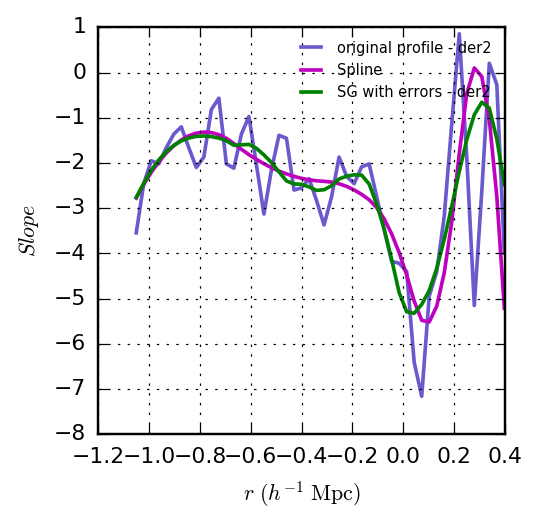

In [23]:
#Picking window_size = 25, 5th order
sg_new = savgol_filter_werror(ld50, 25, 5, np.log((d50-err)/d50), deriv=None)

derivative_sg = der2(lr,sg_new)


plot_pretty()
plt.figure(figsize=(3,3))
plt.xlabel(r'$r\ (h^{-1}\ \rm Mpc)$'); plt.ylabel(r'$Slope$')
#plt.xlim(0.9,3.); plt.ylim(0.1, 50)
#plt.xscale('log'); 
#plt.yscale('log')
plt.plot(lr, (dld50dlr), c='slateblue', lw=1.5, label='original profile - der2')
plt.plot(lr, (slope_density(lr)), c='m', lw=1.5, label='Spline')
plt.plot(lr, derivative_sg, c='g', lw=1.5, label='SG with errors - der2')
#plt.fill_between(r, d50-err, d50+err, facecolor='blue', alpha=0.5)

plt.legend(frameon=False, fontsize=6)
plt.grid()
plt.show()

<font color='blue' size=4> Problem 3: 27 </font>

<b>3. (40 points) <i>Numerical integration.</i></b>

a. (10 points) Use my examples of Richardson extrapolation implementation via recursive function in <a href="https://github.com/a-kravtsov/a330f16/blob/master/ex01.ipynb">ex01.ipynb</a> and trapezoidal integration in <a href="https://github.com/a-kravtsov/a330f16/blob/master/ex02.ipynb">ex02.ipynb</a> to implement a routine performing Romberg integration to a specified relative accuracy $\epsilon$. Don't bother about polynomial fits and extrapolation of $h$ to zero; simply code up recursive calculation of $S_{km}$ (see eq. Use this routine to compute $\sigma(R)$ integral you were computing before with spline:
$$\sigma^2(R)=\frac{1}{2\pi^2}\int_0^{\infty} k^2 P(k) \tilde{W}^2(kR)dk$$
for the top-hat filter:
$$\tilde{W}_{\rm TH}(x)=\frac{3(\sin x-x \cos x)}{x^3},$$
where $x=kR$ is dimensionless. Use the <a href="http://adsabs.harvard.edu/abs/1999ApJ...511....5E">Eisenstein & Hu (1999)</a>  approximation of $P(k)$ from colossus, as shown at the end of <a href="https://github.com/a-kravtsov/a330f16/blob/master/ex02.ipynb">ex02.ipynb</a> (most of you used this already). Test your results by comparing against <a href="http://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.romberg.html">Romberg integration routine from scipy.</a>. Time your and scipy's routines using <a href="http://pythoncentral.io/measure-time-in-python-time-time-vs-time-clock/"><code>time</code> or <code>timeit</code></a> packages. How different is performance on this integral?



In [24]:
#
#3. Numerical Integration 
#
#Part (a)



a=10**-30.
b=100.

def weight(x):
    w = (3/(x**3))*(np.sin(x)-(x*np.cos(x)))
    return w

def summ(range1):
    global sumf
    sumf = 0
    for x in range1:
        sumf = sumf + f(x) 
    return sumf
    
def trap_oper(f,h,k,m):  #Romberg operations done here
   
    if m == 0:
        hd = h/2.**k
        xi = np.arange(a+hd, b-hd, hd)
        dummy = 0.5*hd*(f(a) + f(b)) + hd*summ(xi)
    else:
        fact = 4.**m
        dummy = (fact*trap_oper(f, h, k+1, m-1) - trap_oper(f, h, k, m-1))/(fact-1.)
    return dummy

In [25]:
import time
start_time = time.time()

c = 1/(2*np.pi**2)
epsilon = pow(10.,-4.)

Rlist = np.logspace(np.log10(Rmin),np.log10(Rmax),15)
print Rlist

ps=UnivariateSpline(ka, Pka, s=0.0)

sigma=[]

for R in Rlist:
    
    print 'R is', R
    m=0
    k=0
    relative = 10**20
    integral_old = 0.1
    f = lambda k: (weight(k*R)**2)*(k**2)*ps(k)
    
    while relative > epsilon:
        integral_new = c*trap_oper(f,0.01,m,k)
        relative = np.abs(integral_new-integral_old)/integral_old
        integral_old = integral_new
        m+=1
    
    print 'Integral done'
    sigma.append(integral_new)
    
print("--- %s seconds ---" % (time.time() - start_time))



[  1.00000000e-02   2.46163097e-02   6.05962702e-02   1.49165655e-01
   3.67190796e-01   9.03888235e-01   2.22503927e+00   5.47722558e+00
   1.34829081e+01   3.31899441e+01   8.17013942e+01   2.01118682e+02
   4.95079976e+02   1.21870420e+03   3.00000000e+03]
R is 0.01
Integral done
R is 0.024616309677
Integral done
R is 0.0605962702114
Integral done
R is 0.149165655279
Integral done
R is 0.367190796353
Integral done
R is 0.903888235356
Integral done
R is 2.22503927149
Integral done
R is 5.47722557505
Integral done
R is 13.4829080926
Integral done
R is 33.1899440954
Integral done
R is 81.7013942015
Integral done
R is 201.118682071
Integral done
R is 495.079975968
Integral done
R is 1218.70420033
Integral done
R is 3000.0
Integral done
--- 146.477023125 seconds ---


[  1.00000000e-02   2.46163097e-02   6.05962702e-02   1.49165655e-01
   3.67190796e-01   9.03888235e-01   2.22503927e+00   5.47722558e+00
   1.34829081e+01   3.31899441e+01   8.17013942e+01   2.01118682e+02
   4.95079976e+02   1.21870420e+03   3.00000000e+03]
[50.929274137930427, 44.218224996601052, 30.648940837579367, 19.490539190345331, 11.446076604432871, 6.0648069241565308, 2.8053623588247416, 1.0795178525560734, 0.32079082755563798, 0.066263372964780826, 0.0089345796807237862, 0.00071527017027211265, 3.5702048156816444e-05, 1.4356343953054335e-06, 5.1886346706804297e-08]


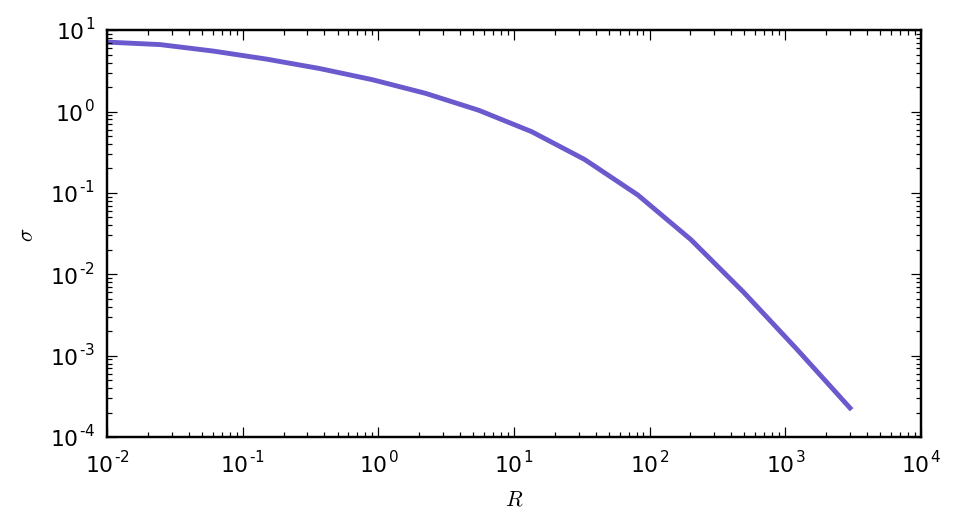

In [37]:
print Rlist
print sigma

plot_pretty()
plt.figure(figsize=(6,3))
plt.xscale('log'); 
plt.yscale('log')
#plt.ylim(1.e-2, 1.e5); 
#plt.xlim(1.e-2, 1.e2)
plt.xlabel(r'$R$'); plt.ylabel(r'$\sigma$')
plt.plot(Rlist, np.sqrt(sigma), '-', c='slateblue', linewidth=2., label=r'$Sigma vs R$')

<font color='blue' size=4> Note, that your upper limit of integration ($k = 100\ h/\rm Mpc$) is not large enough, so, $\sigma(0.01\ \rm Mpc)$ is slightly below the correct value ($\sim 7$ instead of $\sim 8$). </font>

In [29]:
from scipy import integrate
start_time = time.time()

c = 1/(2*np.pi**2)
spline_Pka =UnivariateSpline(ka,Pka,s=0)
Rlist2 = np.logspace(np.log10(Rmin),np.log10(Rmax),100)

romberg_scipy = []
for R in Rlist2:
   
    func_romberg = lambda ka: weight(ka*R)*(ka**2)*spline_Pka(ka)
    result = c*integrate.romberg(func_romberg, 10**-30, 100, show=True)
    romberg_scipy.append(result)
    
print("--- %s seconds ---" % (time.time() - start_time))

Romberg integration of <function vfunc at 0x10d33faa0> from [1e-30, 100]

 Steps  StepSize   Results
     1 100.000000 181.874802 
     2 50.000000 419.195757 498.302743 
     4 25.000000 600.731672 661.243643 672.106370 
     8 12.500000 740.135391 786.603297 794.960607 796.910674 
    16  6.250000 844.136414 878.803421 884.950096 886.378501 886.729355 
    32  3.125000 917.938269 942.538888 946.787919 947.769472 948.010220 948.070124 
    64  1.562500 966.790014 983.073929 985.776265 986.395128 986.546601 986.584271 986.593676 
   128  0.781250 996.284755 1006.116335 1007.652495 1007.999737 1008.084461 1008.105515 1008.110770 1008.112084 
   256  0.390625 1011.979173 1017.210645 1017.950266 1018.113723 1018.153385 1018.163228 1018.165684 1018.166298 1018.166451 
   512  0.195312 1019.370610 1021.834423 1022.142674 1022.209221 1022.225281 1022.229262 1022.230255 1022.230503 1022.230565 1022.230580 
  1024  0.097656 1021.250123 1021.876627 1021.879441 1021.875262 1021.873953 1021.87360

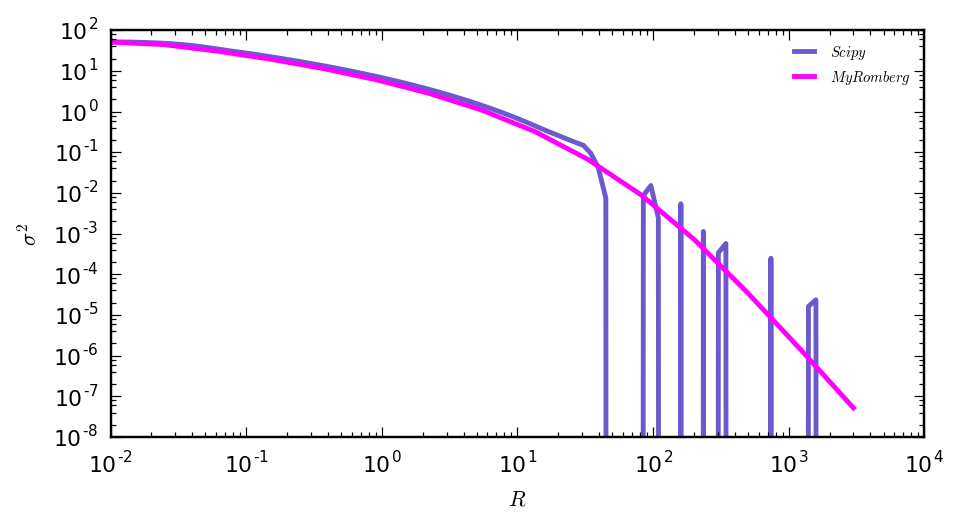

In [38]:
plot_pretty()
plt.figure(figsize=(6,3))
plt.xscale('log'); 
plt.yscale('log')
#plt.ylim(1.e-2, 1.e5); 
#plt.xlim(1.e-2, 1.e2)
plt.xlabel(r'$R$'); plt.ylabel(r'$\sigma^2$')
plt.plot(Rlist2, (romberg_scipy), '-', c='slateblue', linewidth=2., label=r'$Scipy$')
plt.plot(Rlist, (sigma), '-', c='magenta', linewidth=2., label=r'$My Romberg$')
plt.legend(frameon=False, fontsize=6)



<font color='blue' size=4> You limited number of divisions in scipy Romberg (divmax=10), while your routing was allowed to split the interval indefinitely, this is why it performs better. </font>

Reason why scipy Romberg blows up in comparison with my Romberg:

1. I am using lesser number of points for higher R (log-spaced), primarily because my algorithm only 
realistically calculates the integral for 15 R values in ~150-250 seconds (on my computer). 

b. (10 points) Parallelize your Romberg integration routine with MPI by splitting integration interval into independent segments and applying Romberg integration on each one independently. You can use my example of parallelization of the MC integration with mpi4py from <a href="https://github.com/a-kravtsov/a330f16/blob/master/ex02.ipynb">ex02.ipynb</a> or example of parallel computation of integral with trapezoidal quadrature  <a href="http://materials.jeremybejarano.com/MPIwithPython/collectiveCom.html">here</a>. Time computation of the integral for sufficiently large number of points for this problem and the next one (c) for different number of cores. Do you see speed up for larger number of cores?



In [31]:
#pickle.dump()

#Parallelizing with a cPickle P(k) spline carried over to Midway

In [ ]:
#
#3. Numerical Integration 
#

import numpy as np
from mpi4py import MPI as mpi
import string
import sys
import time
import matplotlib.pyplot as plt
#from colossus.cosmology import cosmology
from scipy.interpolate import UnivariateSpline
import cPickle

comm = mpi.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

########################################################
def weight(x):
    w = (3/(x**3))*(np.sin(x)-(x*np.cos(x)))
    return w

def summ(range1):
    global sumf
    sumf = 0
    for x in range1:
        sumf = sumf + f(x) 
    return sumf
    
def trap_oper(f,h,k,m,a,b):
    if m == 0:
        hd = h/2.**k
        xi = np.arange(a+hd, b-hd, hd)
        dummy = 0.5*hd*(f(a) + f(b)) + hd*summ(xi)
    else:
        fact = 4.**m
        dummy = (fact*trap_oper(f, h, k+1, m-1,a,b) - trap_oper(f, h, k, m-1,a,b))/(fact-1.)
    return dummy

################################################################
f1 = open('power_spectrum.dat','rb')
p = cPickle.load(f1)
f1.close()
################################################################
################################################################
Rmin = 0.01
Rmax = 3000


start_time = time.time()
Rlist = np.logspace(np.log10(Rmin),np.log10(Rmax),100)
print Rlist

sigma_parallel=[]

a=10**-30.
b=100.
c = 1/(2*np.pi**2)
epsilon = 10**-4
h = 0.01

n = (b-a)/h
local_n = n/size

local_a = a + rank*local_n*h
local_b = local_a + local_n*h

integral_new = np.zeros(1)
total = np.zeros(1)
#integral_old = np.zeros(1)

for R in Rlist:
    #print 'R is', R
    m=0
    k=0
    
    #x = ka*R;
    f = lambda k: weight(k*R)*(k**2)*p(k)
    #f  = UnivariateSpline(ka, func, s=0.0)
    
    relative = 10**20 #dummymod
    integral_old = 0.1 #dummy
    
    while relative > epsilon:
        integral_new[0] = c*trap_oper(f,h,m,k,local_a,local_b)
        comm.Reduce(integral_new, total, op=mpi.SUM, root=0)
        relative = np.abs(total-integral_old)/integral_old
        integral_old = total
        m+=1
   
    #print 'Integral done'
    if comm.rank == 0:
        print 'For R = %.4f, integral is %.4e' %(R,total)
    
    sigma_parallel.append(total)
    
print("--- %s seconds ---" % (time.time() - start_time))


plt.figure(figsize=(10,6))
plt.plot(Rlist, total, '-', lw=1.5, c='r', label='$\mathrm{\ Parallel}$')
#plt.plot(lk, dlPdlk2,'--', lw=1.5, c='b', label='$\mathrm{\ 2nd\ order}$')
#plt.xlabel('$k\ (h\ \mathrm{Mpc}^{-1})$'); plt.ylabel(r'$d\ln P(k)/d\ln k$')
#plt.xlim(-0.5,0), plt.ylim(-2.8,-1.8)
plt.title('$\mathrm{Sigma}$')
plt.legend(loc='lower left', frameon=False, fontsize=20)
plt.savefig('temp.png')
plt.show()

################################################################


Timings in parallelization:

With (Window function W(x)):<br>
1 core =  108 seconds<br>
2 cores =  61 seconds (I do not trust this, since Midway connection was being erratic.<br> 
4 cores =  65 seconds<br>

R = 100<br>
With (sin(k*R)/k*R)<br>
1 core = 93 seconds<br>
2 cores = 58 seconds<br>
4 cores = 56 seconds<br>

c. (20 points) Apply your own Romberg integration routine to compute 2-point correlation function  from the power spectrum $P(k)$:
$$\xi(r)=\frac{1}{2\pi^2}\int_0^{\infty} \frac{\sin kr}{kr}P(k) k^2 dk.$$
for $r$ from $0.1h^{-1}$ Mpc to $3000h^{-1}$ Mpc (scale of the order of the Hubble scale of the universe) with relative accuracy of $10^{-4}$ on all scales. If calculations are too slow you can run them in parallel using parallelization carried out in b. Think about a possible way to speed up calculation algorithmically (this requires a good awareness of where the issue is and how the integrand behaves.) 


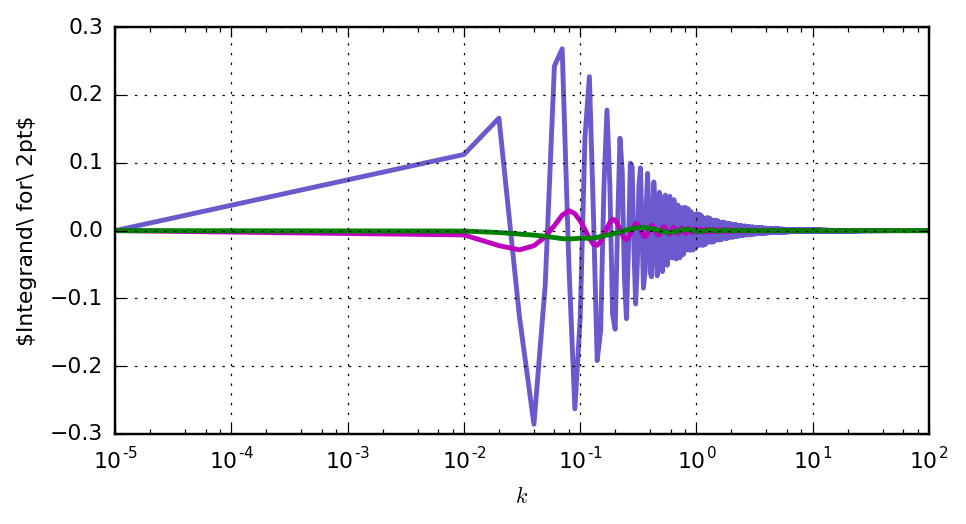

In [46]:
#Plot the integrand : Check behaviour of function
Rtest = [120,1200,2500]
c = 1/(2*np.pi**2)

x1=Rtest[0]*ka
x2=Rtest[1]*ka
x3=Rtest[2]*ka

func1 = c*(np.sin(x1)/x1)*ka**2*Pka
func2 = c*(np.sin(x2)/x2)*ka**2*Pka
func3 = c*(np.sin(x3)/x3)*ka**2*Pka


plot_pretty()
plt.figure(figsize=(6,3))
plt.xscale('log'); 
#plt.yscale('log')
#plt.ylim(1.e-2, 1.e5); 
#plt.xlim(1.e-2, 1.e2)
plt.plot(ka, func1, '-', c='slateblue', linewidth=2., label=r'$\mathrm{Two\ pt\ correlation\ function}$')
plt.plot(ka, func2, '-', c='m', linewidth=2., label=r'$\mathrm{Two\ pt\ correlation\ function}$')
plt.plot(ka, func3, '-', c='g', linewidth=2., label=r'$\mathrm{Two\ pt\ correlation\ function}$')


#plt.plot(ka, spl(ka), lw=0.75, c='r', label='$\mathrm{P(k)\ :\ Spline}$')
plt.xlabel(r'$k$')
plt.ylabel(r'$Integrand\ for\ 2pt\$')
plt.grid()
#plt.savefig('fig/pk.pdf', bbox_inches='tight')
plt.show()

In [43]:
#
# Part 3(c)
#
import time
start_time = time.time()

c = 1/(2*np.pi**2)
epsilon = pow(10.,-4.)

Rlist = np.logspace(np.log10(Rmin),np.log10(Rmax),100)
print Rlist

ps=UnivariateSpline(ka, Pka, s=0.0)

twocorr=[]

for R in Rlist:
    
    print 'R is', R
    m=0
    k=0
    relative = 10**20
    integral_old = 0.1
    #f = lambda k: weight(k*R)*(k**2)*ps(k)
    f = lambda k: (np.sin(k*R)/(k*R))*(k**2)*ps(k)
    
    while relative > epsilon:
        integral_new = c*trap_oper(f,0.01,m,k)
        relative = np.abs(integral_new-integral_old)/integral_old
        integral_old = integral_new
        m+=1
    
    print 'Integral done'
    twocorr.append(integral_new)
    
print("--- %s seconds ---" % (time.time() - start_time))




[  1.00000000e-02   1.13585909e-02   1.29017587e-02   1.46545798e-02
   1.66455377e-02   1.89069853e-02   2.14756710e-02   2.43933361e-02
   2.77073925e-02   3.14716936e-02   3.57474092e-02   4.06040196e-02
   4.61204446e-02   5.23863262e-02   5.95034846e-02   6.75875738e-02
   7.67699599e-02   8.71998567e-02   9.90467496e-02   1.12503151e-01
   1.27787726e-01   1.45148850e-01   1.64868640e-01   1.87267544e-01
   2.12709541e-01   2.41608065e-01   2.74432717e-01   3.11716895e-01
   3.54066469e-01   4.02169616e-01   4.56808013e-01   5.18869533e-01
   5.89362675e-01   6.69432950e-01   7.60381500e-01   8.63686237e-01
   9.81025861e-01   1.11430714e+00   1.26569589e+00   1.43765218e+00
   1.63297030e+00   1.85482415e+00   2.10681887e+00   2.39304936e+00
   2.71816686e+00   3.08745453e+00   3.50691329e+00   3.98335933e+00
   4.52453489e+00   5.13923407e+00   5.83744573e+00   6.63051578e+00
   7.53133161e+00   8.55453145e+00   9.71674229e+00   1.10368500e+01
   1.25363064e+01   1.42394776e+01

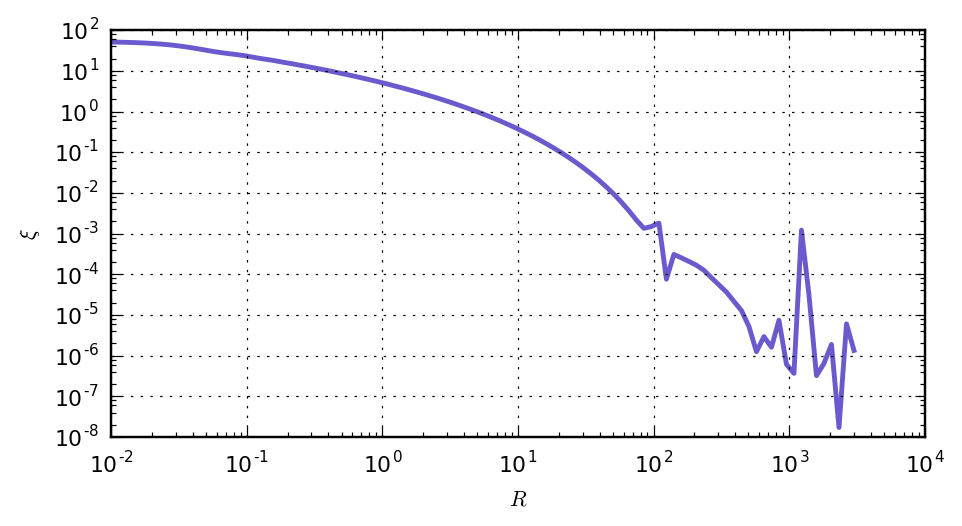

In [44]:
#Plotting the 2-pt corr. function with log-spaced R
#twocorr = np.asarray(twocorr)

plot_pretty()
plt.figure(figsize=(6,3))
plt.xscale('log'); 
plt.yscale('log')
#plt.ylim(1.e-2, 1.e5); plt.xlim(1.e-4, 1.e2)
plt.plot(Rlist, np.abs(twocorr) , '-', c='slateblue', linewidth=2., label=r'$\mathrm{Two\ pt\ correlation\ function}$')
#plt.plot(ka, spl(ka), lw=0.75, c='r', label='$\mathrm{P(k)\ :\ Spline}$')
plt.xlabel(r'$R$')
plt.ylabel(r'$\mathrm{\xi}$')
plt.grid()
#plt.savefig('fig/pk.pdf', bbox_inches='tight')
plt.show()

There are several issues surrounding this integral with [sin(kr)/kr] i.e. sinc function weights. The peak at R~100 is physical, whereas the peaks around R~1000 are numerical as seen from the figure above - discussed in class 

Note: All my calculations are in linearly-spaced k-space. 

Examining solutions:

1. Tracking oscillations in sinc function and characterizing integral for one oscillation. Multiplying this by average number of oscillations seen until the function reaches zero.

2. Exponential damping can be a solution i.e. damping that suppresses higher order R.
3. Using Filon's method or Taylor approximation to the function around higher R.

<font color='blue' size=4> These are nice solutions, and the 2nd one is quite easy to implement. <br />

Did not attempt to remove junk at high $r$. (-13)
</font>